In [1]:
import pandas as pd
import numpy as np
import torch
import fastai 
from fastai.vision.all import *

In [2]:
path = Path('/kaggle/input/sea-animals-image-dataste')

In [3]:
path.ls()

(#23) [Path('/kaggle/input/sea-animals-image-dataste/Penguin'),Path('/kaggle/input/sea-animals-image-dataste/Clams'),Path('/kaggle/input/sea-animals-image-dataste/Lobster'),Path('/kaggle/input/sea-animals-image-dataste/Otter'),Path('/kaggle/input/sea-animals-image-dataste/Eel'),Path('/kaggle/input/sea-animals-image-dataste/Corals'),Path('/kaggle/input/sea-animals-image-dataste/Puffers'),Path('/kaggle/input/sea-animals-image-dataste/Squid'),Path('/kaggle/input/sea-animals-image-dataste/Whale'),Path('/kaggle/input/sea-animals-image-dataste/Sea Urchins')...]

# **Start by createing a DataLoader:=**

In [4]:
sea_animals = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)) 

In [5]:
dls = sea_animals.dataloaders(path)

# **View Samples of our Data:=**

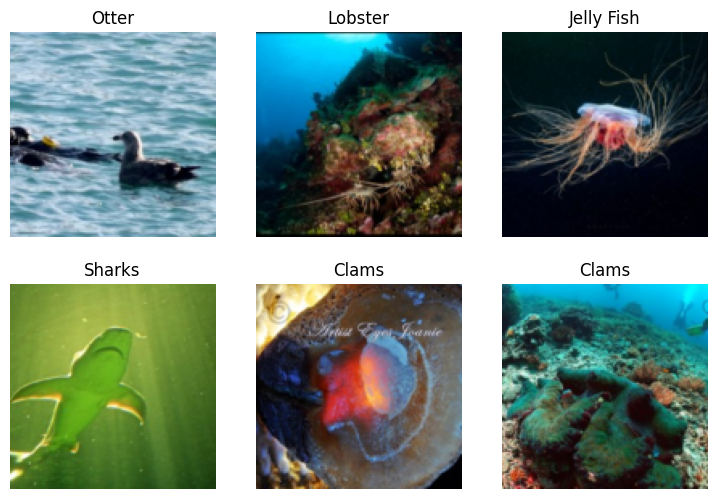

In [6]:
dls.train.show_batch(max_n=6, nrows=2)

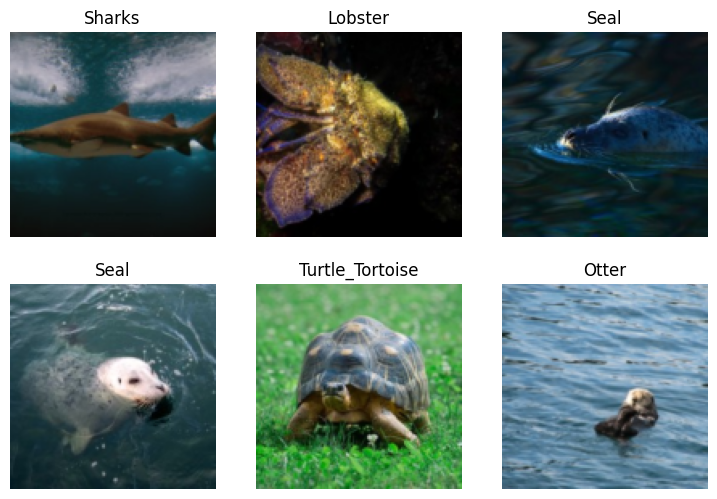

In [7]:
dls.valid.show_batch(max_n=6, nrows=2)

In [8]:
print(dls.vocab)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


**Check the dataset length:**

In [9]:
len(dls.train_ds), len(dls.valid_ds)

(10969, 2742)

# **Initializing our Baseline:=**

**Start with Resnet50 model:**

In [10]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.583653,0.897959,0.256747,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.906342,0.690332,0.204230,00:31
1,0.735208,0.618670,0.176878,00:30
2,0.497518,0.584665,0.165208,00:30
3,0.318944,0.588973,0.159737,00:30
4,0.185354,0.583595,0.153173,00:30
5,0.156026,0.586557,0.152808,00:30


# **Model Interpretation:=**

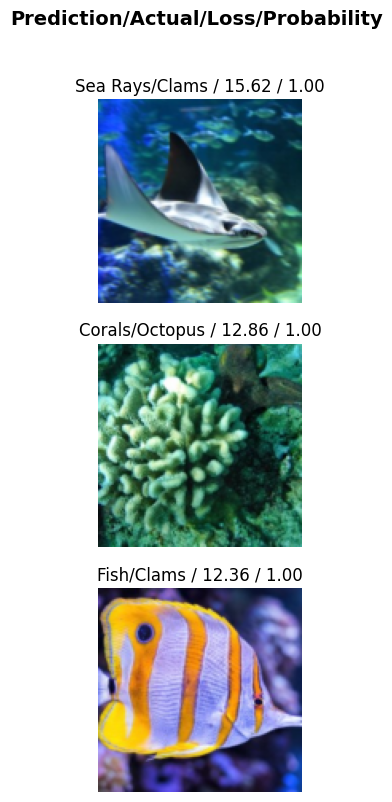

In [11]:
# Get the top losses:=
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3, nrows=3)

# **Image Processing using DataAugmentation (Aug transform)methodolgy:=**

In [12]:
sea_animals = sea_animals.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = sea_animals.dataloaders(path)

# **See our dataset again after we apply Aug_transform:**

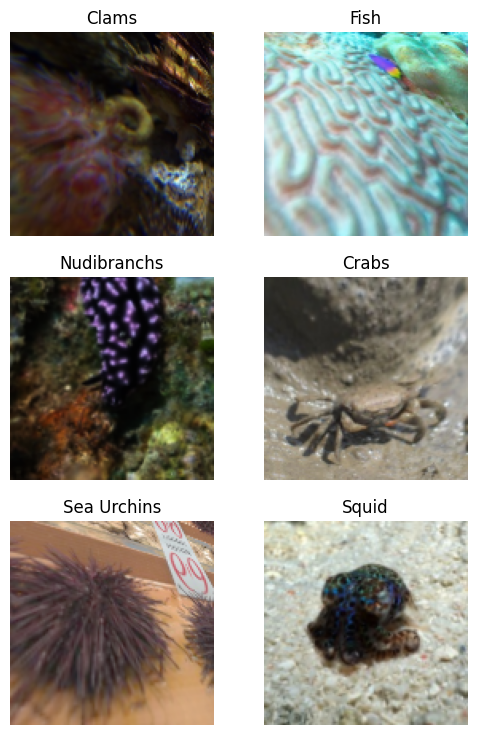

In [13]:
dls.train.show_batch(max_n=6, nrows=3)

# **Train the model:=**

In [14]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.779428,0.911428,0.258570,00:25


epoch,train_loss,valid_loss,error_rate,time
0,1.187885,0.703812,0.208242,00:33
1,0.933866,0.594483,0.176878,00:33
2,0.776323,0.552790,0.157549,00:33
3,0.630578,0.531870,0.155726,00:33
4,0.512117,0.508220,0.148796,00:33
5,0.474961,0.505130,0.144785,00:33


**As we see our model has improved than the last time , next step will try another method that will give us better results.**

# **Presizing:=**

In [15]:
sea_animals = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    get_y= parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [16]:
dls = sea_animals.dataloaders(path)

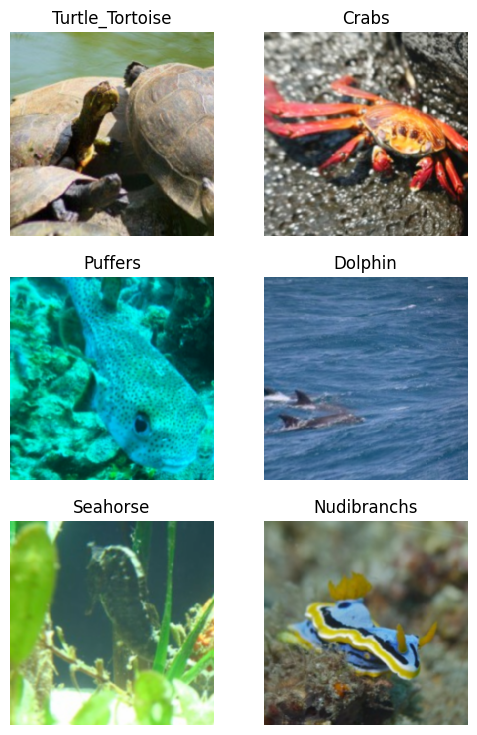

In [17]:
dls.train.show_batch(max_n=6, nrows=3)

# **Make a new training with Presizing method:=**

In [18]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(11)

epoch,train_loss,valid_loss,error_rate,time
0,1.347996,0.757228,0.208607,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.768081,0.531861,0.148432,01:12
1,0.635228,0.465510,0.130197,01:12
2,0.515806,0.451018,0.128738,01:12
3,0.409374,0.441348,0.124362,01:13
4,0.313199,0.440953,0.117797,01:12
5,0.236964,0.433557,0.113056,01:12
6,0.172661,0.433235,0.111962,01:12
7,0.132348,0.454150,0.109409,01:12
8,0.115965,0.457674,0.105398,01:12
9,0.082833,0.457909,0.105398,01:12


# **Model Interpretation:=**

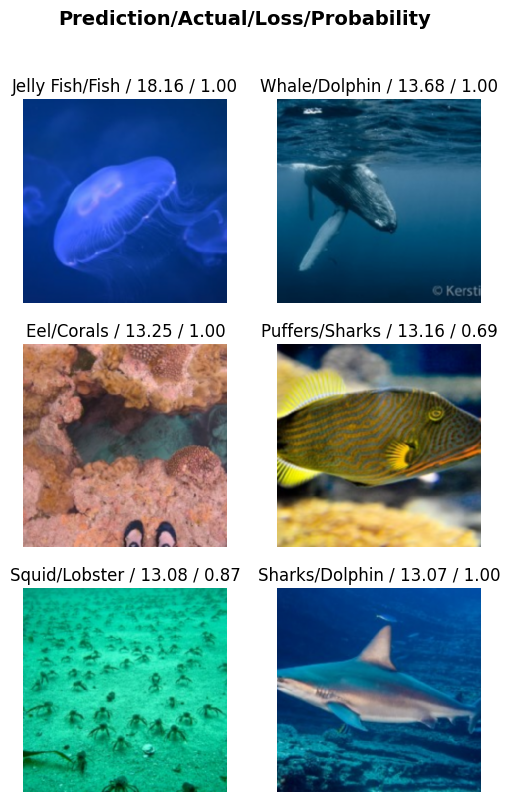

In [19]:
presize_interp = ClassificationInterpretation.from_learner(learn)
presize_interp.plot_top_losses(6, nrows=3)

# **Get the most confused predictions:**

In [20]:
presize_interp.most_confused(min_val=5)

[('Clams', 'Corals', 9),
 ('Fish', 'Corals', 9),
 ('Whale', 'Sharks', 9),
 ('Dolphin', 'Sharks', 7),
 ('Dolphin', 'Whale', 7),
 ('Fish', 'Eel', 7),
 ('Fish', 'Puffers', 6),
 ('Sharks', 'Whale', 6),
 ('Whale', 'Dolphin', 6),
 ('Eel', 'Puffers', 5)]

# **Improving the model by finding the best Learning Rate:**

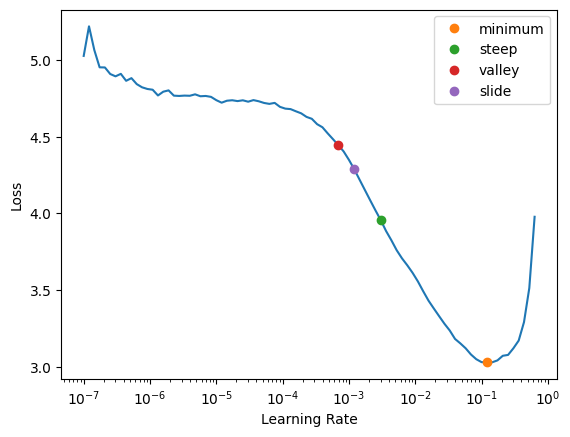

In [21]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
lrs= learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# **Train the model with new suggestive Learning Rate:=**

In [22]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(11, lrs.valley)

epoch,train_loss,valid_loss,error_rate,time
0,1.647230,0.795209,0.225383,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.936547,0.641540,0.180890,01:12
1,0.861194,0.562012,0.153902,01:12
2,0.686410,0.511852,0.148796,01:13
3,0.598451,0.470635,0.136032,01:12
4,0.442209,0.448292,0.127279,01:12
5,0.377750,0.434981,0.112691,01:13
6,0.310846,0.423246,0.116703,01:12
7,0.295605,0.413254,0.112691,01:12
8,0.258313,0.412746,0.111597,01:12
9,0.229006,0.414764,0.114150,01:13


# **Unfreezing the model:=**

**The pretrained models, such as the ResNet model that we are using right now, can be used on data other than this completely and for another task, and this whats called Transfer Learning.**

**Because the model was trained on some other dataset, we might be able to improve it by effectivley removing the final linear layer of the model- which is specifically designed to classifiy the categories in the original pretraining dataset - and replace it with a layer specific to our dataset.**

**From FastAI:**

**We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task, and only adjust them as required for the specifics of our particular task.**

**Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called freezing those pretrained layers.**

**When we call the fine_tune method FastAI does two things:**

**Trains the randomly added layers for one epoch, with all other layers frozen.**

**Unfreezes all of the layers, and trains them all for the number of epochs requested.**

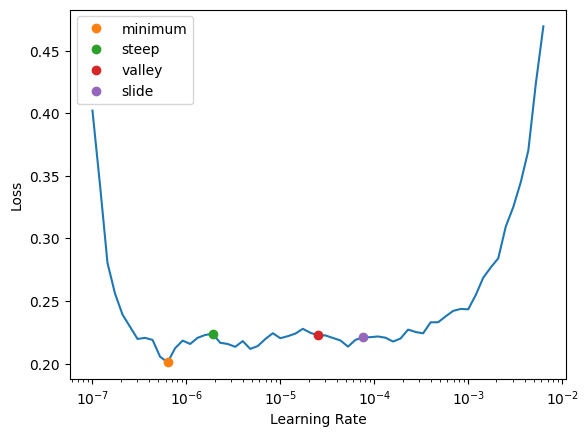

In [23]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [24]:
learn.fit_one_cycle(10, slice(lrs.minimum, lrs.slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.228013,0.415103,0.113056,01:12
1,0.202511,0.419733,0.115974,01:12
2,0.213618,0.419100,0.114880,01:12
3,0.203686,0.419849,0.114150,01:12
4,0.189517,0.417425,0.113786,01:12
5,0.185999,0.418227,0.113056,01:12
6,0.196171,0.421310,0.115974,01:12
7,0.174808,0.416883,0.112327,01:12
8,0.182133,0.414272,0.111233,01:12
9,0.169695,0.420927,0.110868,01:12


# **Model Interpretation:=**

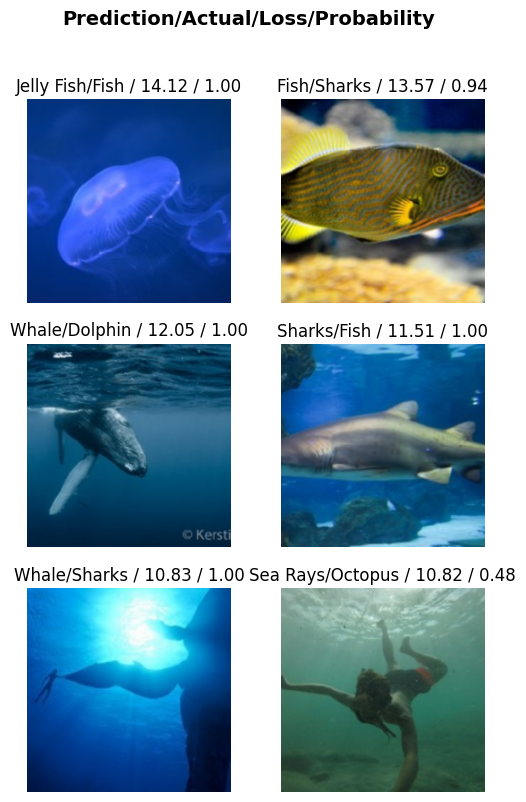

In [25]:
presize_interp_2 = ClassificationInterpretation.from_learner(learn)
presize_interp_2.plot_top_losses(6, nrows=3)